In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import nibabel as nib
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from scipy.stats import pearsonr
import numpy as np

In [2]:
def get_back_to_mat(vec,sym_mat_size):
    sym_mat=np.zeros((sym_mat_size,sym_mat_size))
    k=0
    for i in range(sym_mat_size):
        for j in range(sym_mat_size):
            if i==j:
                sym_mat[i,j]=0
            if i<j:
                sym_mat[i,j]=vec[k]
                k+=1
    for i in range(sym_mat_size):
        for j in range(sym_mat_size):
            if i>j:
                sym_mat[i,j]=sym_mat[j,i]
    return sym_mat
def normalize_time_series(time_series):

    time_series = np.array(time_series)
    mean = np.mean(time_series)
    std = np.std(time_series)
    
    # Avoid division by zero if the std is zero
    if std == 0:
        return time_series - mean
    
    return (time_series - mean) / std
def fisher_r_to_z(correlation_coefficient):
    # Convert the input to a numpy array
    correlation_coefficient = np.array(correlation_coefficient)
    
    # Apply Fisher r-to-z transformation
    return 0.5 * np.log((1 + correlation_coefficient) / (1 - correlation_coefficient))



def partial_correlation(MVC_scores,connectomes,covariates):
    covariates=sm.add_constant(covariates)
    MVC_scores=np.array(MVC_scores, dtype=np.float64)
    covariates=np.array(covariates, dtype=np.float64)
    model_mvc=sm.OLS(MVC_scores,covariates).fit()
    mvc_residuals=model_mvc.resid
    n_features = connectomes.shape[1]
    partial_corrs = np.zeros(n_features)
    p_values = np.zeros(n_features)
    for i in range(n_features):
        feature = connectomes[:, i]
        model_feature = sm.OLS(feature, covariates).fit()
        feature_residuals = model_feature.resid
        
        # Calculate Pearson correlation between the residuals
        partial_corrs[i], p_values[i] = pearsonr(mvc_residuals, feature_residuals)
    return partial_corrs, p_values

def select_features_1d(corrs,pvals,pval_threshold):
    pos_fets_whole=np.zeros_like(corrs)
    neg_fets_whole=np.zeros_like(corrs)
    for i in range(corrs.shape[0]):
        if pvals[i]<pval_threshold:
            if corrs[i]>0:
                pos_fets_whole[i]=1
            elif corrs[i]<0:
                neg_fets_whole[i]=1
    selected_pos_features=np.where(pos_fets_whole>=pval_threshold)
    selected_neg_features=np.where(neg_fets_whole>=pval_threshold)
    return selected_neg_features,selected_pos_features

def select_features(corrs,pvals,pval_threshold,fraction_of_within_threshold_subs):
    num_samples=corrs.shape[1]
    pos_fets_whole=np.zeros_like(corrs)
    neg_fets_whole=np.zeros_like(corrs)
    for i in range(corrs.shape[0]):
        for j in range(corrs.shape[1]):
            if pvals[i,j]<pval_threshold:
                if corrs[i,j]>0:
                    pos_fets_whole[i,j]=1
                elif corrs[i,j]<0:
                    neg_fets_whole[i,j]=1
    pos_fets=np.sum(pos_fets_whole,axis=1)
    neg_fets=np.sum(neg_fets_whole,axis=1)
    acceptance_threshold=int(fraction_of_within_threshold_subs*num_samples)
    selected_pos_features=np.where(pos_fets>=acceptance_threshold)
    selected_neg_features=np.where(neg_fets>=acceptance_threshold)
    selected_neg_features=np.array(selected_neg_features).reshape(-1)
    selected_pos_features=np.array(selected_pos_features).reshape(-1)
    return selected_neg_features,selected_pos_features



from sklearn.linear_model import LinearRegression
def linear_model_builder(fets_model,mvc_model,cov,selected_features):
    
    connectomes=fets_model[:,selected_features]
    connectomes=np.hstack((connectomes,cov))
    print(len(selected_features))
    print(np.shape(connectomes))
    model=LinearRegression()  
    model.fit(connectomes,mvc_model)
    return model

import numpy as np
import statsmodels.api as sm

def recognize_covariate_effect(data, covariate):
    # Ensure inputs are numpy arrays
    data = np.array(data,dtype=np.float64)
    covariate = np.array(covariate,dtype=np.float64)

    
    # Add a constant term for the intercept in linear regression
    covariate_with_intercept = sm.add_constant(covariate)
    
    # Fit a linear regression model
    model = sm.OLS(data, covariate_with_intercept).fit()
    
    # Get the residuals (data with the effect of the covariate removed)
    residuals = model.resid
    
    return residuals, model

def get_train_test_indices(data,proportion):
    # Get the length (shape 0) of the input data
    n_samples = data.shape[0]
    
    # Generate all indices
    all_indices = np.arange(n_samples)
    
    # Shuffle the indices randomly
    np.random.shuffle(all_indices)
    
    # Determine the size of the testing set (1/4 of the data)
    test_size = n_samples // proportion
    
    # Split indices into test and train
    test_indices = all_indices[:test_size]
    train_indices = all_indices[test_size:]
    
    return train_indices, test_indices

def remove_covariate_effect(model,data,covariate):
    temp1=sm.add_constant(covariate)
    if len(temp1)==1:
        temp1=np.concatenate((np.ones((len(temp1),1)),temp1),axis=1)
    temp=model.predict(temp1)
    data=data-temp
    return data


def corr_pval(fp, scores,features, n_jobs=-1):  # n_jobs=-1 uses all available cores
    num_samples=len(fp)
    states_length=len(fp[0])
    corrs = np.zeros((states_length, num_samples))
    pvals = np.zeros((states_length, num_samples))
    for i in range(states_length):
        if i not in features:
            corrs[i,:]=0
            pvals[i,:]=1

    def compute_corr_pval(ii, X_train, y_train, test_index):
        # if ii % 10000 == 0:
        #     print(f"Looking at feature {ii}")
        corr, pval = pearsonr(X_train[:, ii], y_train)
        return (ii, test_index, corr, pval)

    for train_index, test_index in loo.split(fp):
        X_train, X_test = fp[train_index], fp[test_index]
        y_train, y_test = scores[train_index], scores[test_index]

        # if test_index % 100 == 0:
        # print(f"Currently the test index is {test_index}")
        
        # Use Parallel to parallelize over the features (ii loop)
        results = Parallel(n_jobs=n_jobs)(delayed(compute_corr_pval)(ii, X_train, y_train, test_index)
                                          for ii in features)

        # Gather results
        for ii, test_index, corr, pval in results:
            corrs[ii, test_index] = corr
            pvals[ii, test_index] = pval

    return corrs, pvals

def compute_feature_corrs(fet, in_train_random, out_train_random):
    return pearsonr(in_train_random[:, fet], out_train_random)

from sklearn.linear_model import Ridge
def ridge_regressor(input, output, num_iterations, alpha,subs_fraction):

    feature_weights = np.zeros((len(input[0]), num_iterations))
    intercepts = np.zeros(num_iterations)
    
    # Indices for all features
    features = np.arange(len(input[0]))
    model_data = input[:, features]

    for iteration in range(num_iterations):
        if iteration % 1000 == 0:
            print("Iteration number: ", iteration)
        
        # Randomly sample 75% of the data
        num_random_subs = int(len(input) * subs_fraction)
        random_indices = np.random.choice(len(input), num_random_subs, replace=False)
        
        x = model_data[random_indices]
        y = output[random_indices]
        
        # Ridge Regression Model
        model = Ridge(alpha=alpha, max_iter=10000)
        model.fit(x, y)
        
        # Store the weights and intercept
        feature_weights[:, iteration] = model.coef_
        intercepts[iteration] = model.intercept_
    
    return feature_weights, intercepts

def linear_regressor(input, output, num_iterations,subs_fraction):
    """
    Perform linear regression multiple times on randomly sampled subsets of data.

    Parameters:
        input (ndarray): The input feature matrix of shape (n_samples, n_features).
        output (ndarray): The target variable array of shape (n_samples,).
        num_iterations (int): Number of iterations for resampling and fitting.

    Returns:
        feature_weights (ndarray): An array of shape (n_features, num_iterations) containing the weights for each iteration.
        intercepts (ndarray): An array of shape (num_iterations,) containing the intercepts for each iteration.
    """
    # Initialize arrays to store weights and intercepts
    feature_weights = np.zeros((len(input[0]), num_iterations))
    intercepts = np.zeros(num_iterations)

    # Indices for all features
    features = np.arange(len(input[0]))
    model_data = input[:, features]

    for iteration in range(num_iterations):
        if iteration % 1000 == 0:
            print("Iteration number: ", iteration)

        # Randomly sample 90% of the data
        num_random_subs = int(len(input) * subs_fraction)
        random_indices = np.random.choice(len(input), num_random_subs, replace=False)

        x = model_data[random_indices]
        y = output[random_indices]

        # Linear Regression Model
        model = LinearRegression()
        model.fit(x, y)

        # Store the weights and intercept
        feature_weights[:, iteration] = model.coef_
        intercepts[iteration] = model.intercept_

    return feature_weights, intercepts



def order_output_with_interval(input,interval):
    input_in_order=np.argsort(input)
    indices_order=np.concatenate([np.arange(i,len(input),interval) for i in range(interval)])
    new_order_of_indices=input_in_order[indices_order]
    return new_order_of_indices

In [3]:
fingerprints_dir="/home/aghaffari/lcaging_fmri/isbi_2025_fcn/fingerprints"
fp_list=os.listdir(fingerprints_dir)
fp_list=[x for x in fp_list if "conn" in x]
fp_indices=[x[-10:-7] for x in fp_list]
fp_indices=np.unique(fp_indices)
isbi_dir="/home/aghaffari/lcaging_fmri/isbi_2025_fcn"
excel_sheet="LC Aging Subject Data master spreadsheet.xlsx"
sheet=pd.read_excel(os.path.join(isbi_dir,excel_sheet), sheet_name="neuropsych")
demographics_sheet=pd.read_excel(os.path.join(isbi_dir,excel_sheet), sheet_name="demographics")
mvc_data=sheet[['SUBJECT NUMBER','In Scanner MVC S2','In Scanner MVC S3','Workroom MVC S1','Workroom MVC S2','Workroom MVC S3','Visual Session']]
demographics_data=demographics_sheet[['SUBJECT NUMBER_1',"SEX","AGE AT BAP SESSION 1"]]
final_df=pd.DataFrame(columns=['SUBJECT NUMBER','Visual Session','Workroom MVC S1','Workroom MVC S2','Workroom MVC S3','sex','age'])
mvc_sub_list=mvc_data['SUBJECT NUMBER'].str[-3:].tolist()
demographics_sub_list=demographics_data['SUBJECT NUMBER_1'].str[-3:].tolist()
k=0
for ii in range(len(fp_indices)):
    ## find the row in the mvc data that contains the current subject number
    curr_sub_id=fp_indices[ii]
    if (curr_sub_id not in mvc_sub_list):
        print("The current subject is not in the mvc data: ",curr_sub_id)
        continue
    else:
        mvc_ind=mvc_sub_list.index(curr_sub_id)
        current_row_mvc=mvc_data.iloc[mvc_ind]
        final_df.loc[k,'SUBJECT NUMBER']=current_row_mvc['SUBJECT NUMBER']
        final_df.loc[k,'Visual Session']=current_row_mvc['Visual Session']
        final_df.loc[k,'Workroom MVC S1']=current_row_mvc['Workroom MVC S1']
        final_df.loc[k,'Workroom MVC S2']=current_row_mvc['Workroom MVC S2']
        final_df.loc[k,'Workroom MVC S3']=current_row_mvc['Workroom MVC S3']
        k=k+1

k=0
for mio in range(len(final_df)):
    curr_sub_id=final_df.iloc[mio]['SUBJECT NUMBER'][-3:]
    if curr_sub_id in demographics_sub_list:
        demographics_ind=demographics_sub_list.index(curr_sub_id)
        current_row_demographics=demographics_data.iloc[demographics_ind]
        final_df.loc[k,'sex']=current_row_demographics['SEX']
        final_df.loc[k,'age']=current_row_demographics['AGE AT BAP SESSION 1']
        k=k+1
    if curr_sub_id=='136':
        final_df.loc[k,'sex']=current_row_demographics['SEX']='Female'
        final_df.loc[k,'age']=current_row_demographics['AGE AT BAP SESSION 1']=72
        k=k+1

for ii in range(len(final_df)):
    current_row=final_df.iloc[ii]
    #if current_row['Workroom MVC S1'] is a nan:
    mio=0
    if pd.isnull(current_row['Workroom MVC S2']):
        mio=mio+1
        empty='Workroom MVC S2'
        nonempty='Workroom MVC S3'
    if pd.isnull(current_row['Workroom MVC S3']):
        mio=mio+1
        empty='Workroom MVC S3'
        nonempty='Workroom MVC S2'
    if ((mio==1)&(pd.isnull(current_row['Workroom MVC S1'])==False)):
        final_df.loc[ii,empty]=(current_row['Workroom MVC S1']+current_row[nonempty])/2
    if ((mio==2)&(pd.isnull(current_row['Workroom MVC S1'])==False)):
        final_df.loc[ii,'Workroom MVC S2']=current_row['Workroom MVC S1']
        final_df.loc[ii,'Workroom MVC S3']=current_row['Workroom MVC S1']
        
    print("for subject number: ",current_row['SUBJECT NUMBER'],"the mvcs are nan: ",mio)
        
## drop the Nan having rows from the final_df
final_df=final_df.dropna()
final_list=final_df['SUBJECT NUMBER'].str[-3:].tolist()
final_fp_indices=[x for x in fp_indices if x in final_list]


for subject number:  BAP003 the mvcs are nan:  0
for subject number:  BAP102 the mvcs are nan:  0
for subject number:  BAP103 the mvcs are nan:  0
for subject number:  BAP104 the mvcs are nan:  0
for subject number:  BAP106 the mvcs are nan:  0
for subject number:  BAP107 the mvcs are nan:  0
for subject number:  BAP108 the mvcs are nan:  0
for subject number:  BAP110 the mvcs are nan:  0
for subject number:  BAP111 the mvcs are nan:  0
for subject number:  BAP114 the mvcs are nan:  0
for subject number:  BAP116 the mvcs are nan:  0
for subject number:  BAP117 the mvcs are nan:  0
for subject number:  BAP118 the mvcs are nan:  0
for subject number:  BAP120 the mvcs are nan:  0
for subject number:  BAP121 the mvcs are nan:  0
for subject number:  BAP123 the mvcs are nan:  0
for subject number:  BAP124 the mvcs are nan:  0
for subject number:  BAP125 the mvcs are nan:  0
for subject number:  BAP128 the mvcs are nan:  0
for subject number:  BAP129 the mvcs are nan:  0
for subject number: 

/tmp/ipykernel_32936/2972056038.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[k,'sex']=current_row_demographics['SEX']='Female'
/tmp/ipykernel_32936/2972056038.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[k,'age']=current_row_demographics['AGE AT BAP SESSION 1']=72


In [4]:
## reading the input and output data
loo=LeaveOneOut()
sex=final_df['sex'].values
sex_binary=np.zeros(len(sex))
for ii in range(len(sex_binary)):
    if sex[ii]=="Male":
        sex_binary[ii]=1
age=final_df['age'].values
covariates=np.vstack((sex_binary,age)).T

sample_fp_add="/home/aghaffari/lcaging_fmri/isbi_2025_fcn/fingerprints/auditory_conn_117.pickle"
with open(sample_fp_add, 'rb') as f:
    sample_fp = pickle.load(f)

aud_fps=np.zeros((len(final_fp_indices),sample_fp.shape[0]))
vis_fps=np.zeros((len(final_fp_indices),sample_fp.shape[0]))


for (i,sub) in enumerate(final_fp_indices):
    aud_fp_add=os.path.join(fingerprints_dir,"auditory_conn_"+sub+".pickle")
    vis_fp_add=os.path.join(fingerprints_dir,"visual_conn_"+sub+".pickle")
    with open(aud_fp_add, 'rb') as f:
        aud_fp = pickle.load(f)
    with open(vis_fp_add, 'rb') as f:
        vis_fp = pickle.load(f)
    aud_fps[i,:]=aud_fp
    vis_fps[i,:]=vis_fp
# vis_mean=np.mean(vis_fps,axis=0)
# aud_mean=np.mean(aud_fps,axis=0)
## demean the fingerprints

mvc_ses1=np.array(final_df['Workroom MVC S1'].values)
mvc_ses2=np.array(final_df['Workroom MVC S2'].values)
mvc_ses3=np.array(final_df['Workroom MVC S3'].values)
mvc1=np.mean(np.vstack((mvc_ses1,mvc_ses2,mvc_ses3)),axis=0)

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
task="visual"
if task=="visual":
    input_data1=vis_fps
elif task=="auditory":
    input_data1=aud_fps
num_folds=4
folds=np.array_split(np.arange(len(final_fp_indices)),num_folds)
num_features=[5,10,20,50,60,70,75,80,90,100,120,150,175,200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
predictions=np.zeros((len(final_fp_indices),len(num_features)))
reordered_output_args=order_output_with_interval(mvc1,num_folds)
mvc=mvc1[reordered_output_args]
reordered_covariates_out=covariates[reordered_output_args]
input_data=input_data1[reordered_output_args]
for fi,fold in enumerate(folds):
    print("fold number: ",fi)
    covariate_fixed_output=np.zeros_like(mvc)
    test_indices=fold
    train_indices=np.setdiff1d(np.arange(len(final_fp_indices)),test_indices)
    x_train_i,y_train,x_test_i,y_test=input_data[train_indices],mvc[train_indices],input_data[test_indices],mvc[test_indices]
    x_train,x_test=np.zeros_like(x_train_i),np.zeros_like(x_test_i)
    for feature in range(len(x_train[0])):
        x_train[:,feature]=(x_train_i[:,feature]-np.min(x_train_i[:,feature]))/(np.max(x_train_i[:,feature])-np.min(x_train_i[:,feature]))
        x_test[:,feature]=(x_test_i[:,feature]-np.min(x_train_i[:,feature]))/(np.max(x_train_i[:,feature])-np.min(x_train_i[:,feature]))
    ## remove covariate effect
    y_train_cr, model = recognize_covariate_effect(y_train, reordered_covariates_out[train_indices])
    y_test_cr = remove_covariate_effect(model, y_test, reordered_covariates_out[test_indices])
    covariate_fixed_output[test_indices]=y_test_cr
    covariate_fixed_output[train_indices]=y_train_cr
    corrs0,pvals0=np.zeros((len(x_train[0]))),np.zeros((len(x_train[0])))
    for feature in range(len(x_train[0])):
        corrs0[feature],pvals0[feature]=pearsonr(x_train[:,feature],covariate_fixed_output[train_indices])
    neg0,pos0=select_features_1d(corrs0,pvals0,0.1)
    features_step1=np.concatenate((neg0[0],pos0[0]))
    num_random_iterations=200
    fractions=[0.5,0.6,0.7,0.8,0.9]
    corrs1,pvals1=np.zeros((len(x_train[0]),num_random_iterations)),np.ones((len(x_train[0]),num_random_iterations))
    for random_iteration in range(num_random_iterations):
        chosen_fraction=np.random.choice(fractions)
        num_samples=int(chosen_fraction*len(train_indices))
        random_indices=np.random.choice(train_indices,num_samples,replace=False)
        x_train_random=input_data[random_indices]
        y_train_random=covariate_fixed_output[random_indices]
        for ft2 in features_step1:
            corrs1[ft2,random_iteration],pvals1[ft2,random_iteration]=pearsonr(x_train_random[:,ft2],y_train_random)
    # corrs1_mean,pvals1_mean=np.mean(corrs1,axis=1),np.mean(pvals1,axis=1)
    for iff,num_feature in enumerate(num_features):
        ## choose the num_feature features with the lowest pvals
        pvals_sorted=np.argsort(pvals0)
        selected_features=pvals_sorted[:num_feature]
        print(selected_features)
        model=LinearRegression()
        model.fit(x_train[:,selected_features],covariate_fixed_output[train_indices])
        predictions[test_indices,iff]=model.predict(x_test[:,selected_features])

fold number:  0
[15610  1479   592  1782   271]
[15610  1479   592  1782   271 11184 12374  5609  2195 11722]
[15610  1479   592  1782   271 11184 12374  5609  2195 11722 12802 13121
 15685 10921 13005 21567 22526 17393 15649  8098]
[15610  1479   592  1782   271 11184 12374  5609  2195 11722 12802 13121
 15685 10921 13005 21567 22526 17393 15649  8098 22268 12839 15613 22291
  8249  2312  2262  2205  1788   988 14626 15519   699 16182   516 20563
  7792 12087 10905  1375 15888 13504 17288  1269 11790 21285  2203   908
 17369  7866]
[15610  1479   592  1782   271 11184 12374  5609  2195 11722 12802 13121
 15685 10921 13005 21567 22526 17393 15649  8098 22268 12839 15613 22291
  8249  2312  2262  2205  1788   988 14626 15519   699 16182   516 20563
  7792 12087 10905  1375 15888 13504 17288  1269 11790 21285  2203   908
 17369  7866   802  1477  1369 12813  8259 15590  1370 17392 14710  8051]
[15610  1479   592  1782   271 11184 12374  5609  2195 11722 12802 13121
 15685 10921 13005 215

PearsonRResult(statistic=0.1298717955358878, pvalue=0.3588034187554426)


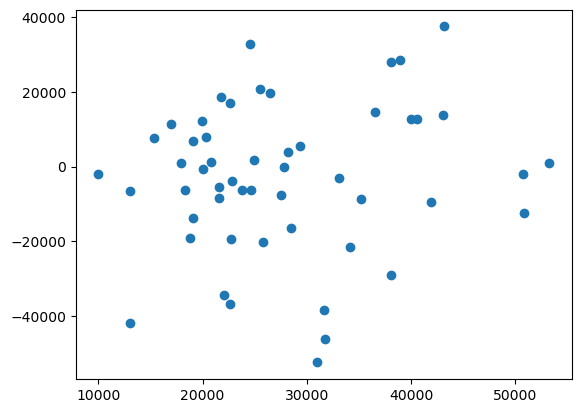

In [77]:
plt.scatter(mvc,predictions[:,3])
print(pearsonr(mvc,predictions[:,3]))  

In [7]:
## import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
task="visual"
if task=="visual":
    input_data1=vis_fps
elif task=="auditory":
    input_data1=aud_fps
for feature in range(len(input_data1[0])):
    input_data1[:,feature]=(input_data1[:,feature]-np.min(input_data1[:,feature]))/(np.max(input_data1[:,feature])-np.min(input_data1[:,feature]))
num_outer_folds=5
reordered_output_args=order_output_with_interval(mvc,num_outer_folds)
output=mvc[reordered_output_args]
reordered_covariates_out=covariates[reordered_output_args]
input_data=input_data1[reordered_output_args]
num_inner_folds=4
out_folds=np.array_split(np.arange(len(output)),num_outer_folds)
FS_random_iterations=30
epsilons=[0.001,0.01,0.1,0.5,1]
cs=[0.01,0.1,1,10,100]
for f_o,outer_fold in enumerate(out_folds):
    output_data_covariate_fixed=np.zeros_like(output)
    outer_test_ind=outer_fold
    print("outer:",outer_test_ind)
    outer_train_ind=[x for x in np.arange(len(output)) if x not in outer_test_ind]
    #print("outer train:",outer_train_ind)
    y_out_train,y_out_test=output[outer_train_ind],output[outer_test_ind]
    x_out_train,x_out_test=input_data[outer_train_ind],input_data[outer_test_ind]
    cov_out_train,cov_out_test=reordered_covariates_out[outer_train_ind],reordered_covariates_out[outer_test_ind]
    y_tr_cr,y_tr_model=recognize_covariate_effect(y_out_train,cov_out_train)  ## y train after removing the covariate effect and the model to remove
    y_ts_cr=remove_covariate_effect(y_tr_model,y_out_test,cov_out_test)   ## y test after removing the covariate effect
    output_data_covariate_fixed[outer_train_ind]=y_tr_cr
    output_data_covariate_fixed[outer_test_ind]=y_ts_cr
    in_folds=np.array_split(outer_train_ind,num_inner_folds)
    # fold_pos_predictions=np.zeros(len(x_out_train))
    # fold_neg_predictions=np.zeros(len(x_out_train))
    fold_predictions=np.zeros((len(epsilons),len(cs),len(x_out_train)))
    len_prev_fold=0
    for f_i,inner_fold in enumerate(in_folds):
        inner_test_ind=inner_fold
        current_indices = range(len_prev_fold, len_prev_fold + len(inner_test_ind))
        print("current indices:",current_indices)
        inner_train_ind=[x for x in outer_train_ind if x not in inner_test_ind]
        y_in_train,y_in_test=output_data_covariate_fixed[inner_train_ind],output_data_covariate_fixed[inner_test_ind]
        x_in_train,x_in_test=input_data[inner_train_ind],input_data[inner_test_ind]
        corrs0_in,pvals0_in=np.zeros(len(x_in_train[0])),np.zeros(len(x_in_train[0]))
        for fet in range(len(x_in_train[0])):
            corrs0_in[fet],pvals0_in[fet]=pearsonr(x_in_train[:,fet],y_in_train)
        neg0_in,pos0_in=select_features_1d(corrs0_in,pvals0_in,0.01)
        neg0_in,pos0_in=neg0_in[0],pos0_in[0]
        features_step1=np.concatenate((neg0_in,pos0_in))
        corrs1_in,pvals1_in=corr_pval(x_in_train,y_in_train,features_step1)
        neg1_in,pos1_in=select_features(corrs1_in,pvals1_in,0.05,0.99)
        features_step2=np.concatenate((neg1_in,pos1_in))
        corrs2_in,pvals2_in=np.zeros((len(x_in_train[0]),FS_random_iterations)),np.zeros((len(x_in_train[0]),FS_random_iterations))
        num_random_subs=int(len(x_in_train)*0.7)
        for kk in range(len(pvals2_in)):
            if kk not in features_step2:
                pvals2_in[kk,:]=1
                corrs2_in[kk,:]=0
        for random_iter in range(FS_random_iterations):
            random_indices=np.random.choice(len(x_in_train),num_random_subs,replace=False)
            x_in_train_random,y_in_train_random=x_in_train[random_indices],y_in_train[random_indices]
            results = Parallel(n_jobs=-1)(delayed(compute_feature_corrs)(fet, x_in_train_random, y_in_train_random)
                            for fet in features_step2)
            mio=0
            for fet in features_step2:
                corrs2_in[fet,random_iter],pvals2_in[fet,random_iter]=results[mio]
                mio=mio+1
        neg2_in,pos2_in=select_features(corrs2_in,pvals2_in,0.1,0.99)
        neg_features=np.intersect1d(np.intersect1d(neg0_in,neg1_in),neg2_in)
        pos_features=np.intersect1d(np.intersect1d(pos0_in,pos1_in),pos2_in)
        selected_features=np.concatenate((neg_features,pos_features))
        for ie,e in enumerate(epsilons):
            for ic,c in enumerate(cs):
                model=SVR(kernel='linear',epsilon=e,C=c)
                model.fit(x_in_train[:,selected_features],y_in_train)
                y_pred=model.predict(x_in_test[:,selected_features])
                print(y_pred)
                fold_predictions[ie,ic,current_indices]=y_pred
        # weights,intercepts=linear_regressor(x_in_train[:,selected_features],y_in_train,1000,0.8)
        # w_m=np.mean(weights,axis=1)
        # i_m=np.mean(intercepts)
        # y_pred=np.dot(x_in_test[:,selected_features],w_m)+i_m
        # pos_features_sum=np.sum(x_in_train[:,pos_features],axis=1)
        # neg_features_sum=np.sum(x_in_train[:,neg_features],axis=1)
        # pos_model=LinearRegression()
        # neg_model=LinearRegression()
        # pos_model.fit(pos_features_sum.reshape(-1,1),y_in_train)
        # neg_model.fit(neg_features_sum.reshape(-1,1),y_in_train)
        # y_pred_pos=pos_model.predict(np.sum(x_in_test[:,pos_features],axis=1).reshape(-1,1))
        # y_pred_neg=neg_model.predict(np.sum(x_in_test[:,neg_features],axis=1).reshape(-1,1))
        # fold_pos_predictions[current_indices]=y_pred_pos
        # fold_neg_predictions[current_indices]=y_pred_neg
        len_prev_fold=len_prev_fold+len(inner_test_ind)
    preds=fold_predictions
        # pos_preds=fold_pos_predictions
        # neg_preds=fold_neg_predictions
    
        

outer: [ 0  1  2  3  4  5  6  7  8  9 10]
current indices: range(0, 11)
[267.36536573 267.38064283 267.37556038 267.46723264 267.37758435
 267.41392037 267.41274318 267.42906868 267.41781431 267.42325833
 267.41784777]
[267.11039784 267.26316886 267.21234438 268.129067   267.23258409
 267.59594433 267.58417239 267.7474274  267.63488373 267.68932385
 267.63521827]
[264.56071898 266.08842914 265.5801844  274.74741057 265.78258151
 269.41618387 269.29846451 270.93101454 269.80557783 270.34997912
 269.80892329]
[239.06393034 254.34103195 249.2585846  340.93084624 251.28255565
 287.61857933 286.44138563 302.76688602 291.51251891 296.95653183
 291.54597351]
[ -15.90395607  136.86706005   86.04258654 1002.76520297  106.28229711
  469.64253387  457.87059691  621.12560079  508.58192964  563.02205888
  508.9164757 ]
[267.36536573 267.38064283 267.37556038 267.46723264 267.37758435
 267.41392037 267.41274318 267.42906868 267.41781431 267.42325833
 267.41784777]
[267.11039784 267.26316886 267.2123

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LinearRegression
task="visual"
if task=="visual":
    input_data1=vis_fps
elif task=="auditory":
    input_data1=aud_fps
for feature in range(len(input_data1[0])):
    input_data1[:,feature]=(input_data1[:,feature]-np.min(input_data1[:,feature]))/(np.max(input_data1[:,feature])-np.min(input_data1[:,feature]))
num_outer_folds=5
reordered_output_args=order_output_with_interval(mvc,num_outer_folds)
output=mvc[reordered_output_args]
reordered_covariates_out=covariates[reordered_output_args]
input_data=input_data1[reordered_output_args]
out_folds=np.array_split(np.arange(len(output)),num_outer_folds)
num_measurements=1
neg_predictions=np.zeros((num_measurements,len(input_data)))
pos_predictions=np.zeros((num_measurements,len(input_data)))
for measurement in range(num_measurements):
    num_folds=num_outer_folds
    folds = np.array_split(np.arange(len(output)), num_folds)
    
    for current_fold in folds:
        print("Current fold: ",current_fold)
        test_indices=current_fold
        
        train_indices=[x for x in np.arange(len(output)) if x not in test_indices]
        in_train_i,in_test_i=input_data[train_indices],input_data[test_indices]
        in_train,in_test=in_train_i,in_test_i
        # in_train,in_test=np.zeros_like(in_train_i),np.zeros_like(in_test_i)
        # for fet in range(len(input_data[0])):
        #     in_train[:,fet],feature_cov_model=recognize_covariate_effect(in_train_i[:,fet],covariates[train_indices])
        #     in_test[:,fet]=remove_covariate_effect(feature_cov_model,in_test_i[:,fet],covariates[test_indices])
        out_train_i,out_test_i=output[train_indices],output[test_indices]
        out_train,train_cov_model=recognize_covariate_effect(out_train_i,covariates[train_indices])
        out_test=remove_covariate_effect(train_cov_model,out_test_i,covariates[test_indices])
        corrs0,pvals0=np.zeros(len(input_data[0])),np.zeros(len(input_data[0]))
        
        print("Whole set:")
        for fet in range(len(input_data[0])):
            corrs0[fet],pvals0[fet]=pearsonr(in_train[:,fet],out_train)
        print("Leave one out:")
        neg0,pos0=select_features_1d(corrs0,pvals0,0.005)
        neg0=neg0[0]
        pos0=pos0[0]
        features_step1=np.concatenate((neg0,pos0))
        corrs1,pvals1=corr_pval(in_train,out_train,features_step1)
        neg1,pos1=select_features(corrs1,pvals1,0.01,0.99)
        features_step2=np.concatenate((neg1,pos1))
        num_random_iterations=50
        num_random_subs=int(len(in_train)*0.8)
        corrs2=np.zeros((len(input_data[0]),num_random_iterations))
        pvals2=np.zeros((len(input_data[0]),num_random_iterations))
        for kk in range(len(pvals2)):
            if kk not in features_step2:
                pvals2[kk,:]=1
                corrs2[kk,:]=0
        print("Random:")
        for random_iter in range(num_random_iterations):
            if random_iter%10==0:
                print("Random iteration: ",random_iter)
            random_subs_indices=np.random.choice(len(in_train),num_random_subs,replace=False)
            in_train_random=in_train[random_subs_indices]
            out_train_random=out_train[random_subs_indices]
            results = Parallel(n_jobs=-1)(delayed(compute_feature_corrs)(fet, in_train_random, out_train_random)
                                    for fet in features_step2)
            mio=0
            for fet in features_step2:
                corrs2[fet,random_iter],pvals2[fet,random_iter]=results[mio]
                mio=mio+1


        neg2,pos2=select_features(corrs2,pvals2,0.1,0.7)
        neg_features=np.intersect1d(np.intersect1d(neg0,neg1),neg2)
        print(neg_features)
        pos_features=np.intersect1d(np.intersect1d(pos0,pos1),pos2)
        print("Len of the poitive and negative features are: ",len(pos_features),len(neg_features),"respectively")
        # selected_features=np.concatenate((neg_features,pos_features))
        # weights,intercepts=ridge_regressor(in_train[:,selected_features],out_train,5000,0.2,0.85)
        # weights,intercepts=linear_regressor(in_train[:,selected_features],out_train,5000,0.85)
        # w_m=np.mean(weights,axis=1)
        # i_m=np.mean(intercepts)
        # predictions[measurement,test_indices]=np.dot(in_test[:,selected_features],w_m)+i_m
        if len(neg_features)>0:
            negative_model=LinearRegression()
            negative_model.fit(np.sum(in_train[:,neg_features],axis=1).reshape(-1,1),out_train)
            neg_predictions[measurement,test_indices]=negative_model.predict(np.sum(in_test[:,neg_features],axis=1).reshape(-1,1))
        if len(pos_features)>0:
            positive_model=LinearRegression()
            positive_model.fit(np.sum(in_train[:,pos_features],axis=1).reshape(-1,1),out_train)
            pos_predictions[measurement,test_indices]=positive_model.predict(np.sum(in_test[:,pos_features],axis=1).reshape(-1,1))
        
# preds=np.mean(predictions,axis=0)
# add="/home/aghaffari/lcaging_fmri/isbi_2025_fcn"
# pickle_name="visual_predictions_"+str(num_measurements)+"_measurements_.pickle"
# with open(os.path.join(add,pickle_name), 'wb') as f:
#     pickle.dump(preds, f)

PearsonRResult(statistic=0.18229515124540016, pvalue=0.19585097019147085)


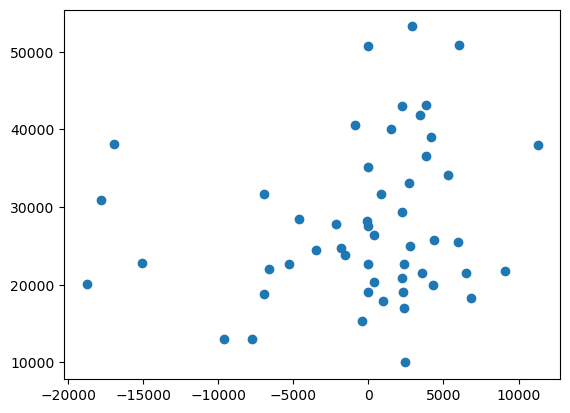

In [112]:
plt.plot(neg_predictions[0],output,'o')
print(pearsonr(neg_predictions[0],output))

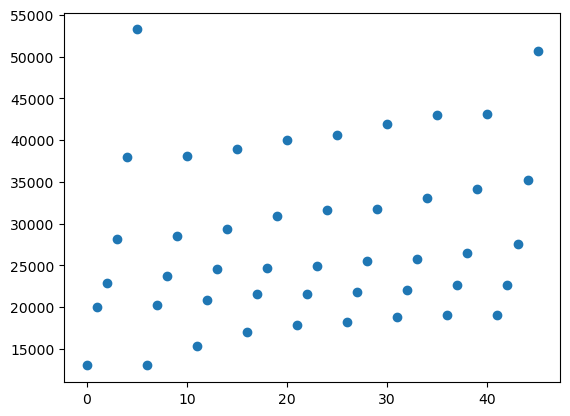

In [106]:
plt.plot(np.arange(len(output[train_indices])),output[train_indices],'o')